## Fitting with our dataset

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import gepard as g # NeuralModel with Dispersion relation added 
from gepard import model, fitter, data, plots
import gepard.plots as gplot
from gepard.fits import GLO15new, AUTIpts, ALUIpts
print('Gepard version = {}'.format(g.__version__))

Gepard version = 0.9.11b0


In [3]:
import gmaster as gm
from gmaster.fits import th_KM15, th_KM10b # need KM15 for simulated data
th15 = th_KM15
from gmaster.constants import Mp2, toTeX

In [4]:
import torch
import numpy as np 
#np.set_printoptions(legacy='1.25')
import matplotlib
import matplotlib.pyplot as plt
import shelve, logging, copy
logging.basicConfig(level=logging.ERROR) 
import pandas as pd 
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm


### To add our data files to gepard


In [5]:
sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/')
#sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepardTorch/gepard/src/gtorch')
import mydatafiles
from mydatafiles import ep2epgamma

mydset = g.data.loaddata(mydatafiles)
mydset.update(g.data.loaddata(ep2epgamma))

In [6]:
# To have nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : '\n'.join([r'\usepackage{amssymb}', r'\usepackage{amsmath}'])}
plt.rcParams.update(params)

In [7]:
fitpoints = mydset[182] + mydset[192] + g.dset[101] + g.dset[102] + g.dset[8]
g.describe_data(fitpoints)

#fitpoints1 =  g.dset[8] + g.dset[101] + g.dset[102] 
#g.describe_data(fitpoints1)

#g.dset[7] it worked # g.dset[6] didn't work # + g.dset[82] # mydset[325] + mydset[98], dset[91] did not work

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
49 x ALU     CLAS    -1     182 arxiv.org/pdf/2211.11274
32 x ALU     CLAS    -1     192 arxiv:2211.11274
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 237


In [8]:
# For easier manipulations we transform some datasets to pandas frames
data = mydset[182]
BSA = data.df()   # ALU by CLAS 2022
data = g.dset[102]
BSS = data.df()  # CLAS 2015
data = g.dset[101]
BSD = data.df()  # CLAS 2015

In [9]:
# Bins can be defined as ranges within the following limiting values:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26]

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

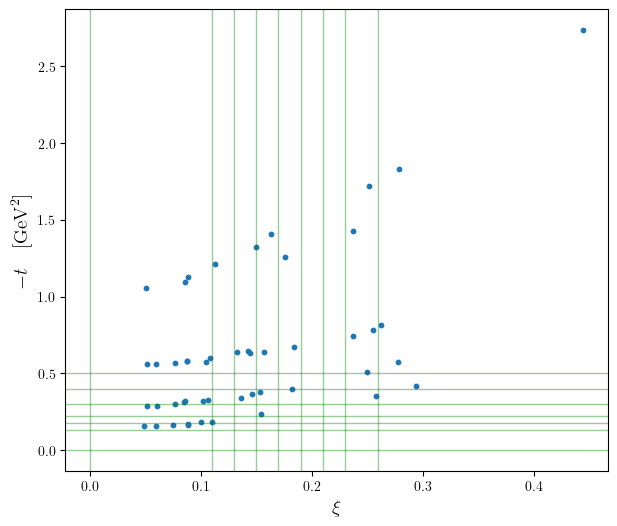

In [10]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSA.xi, BSA.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

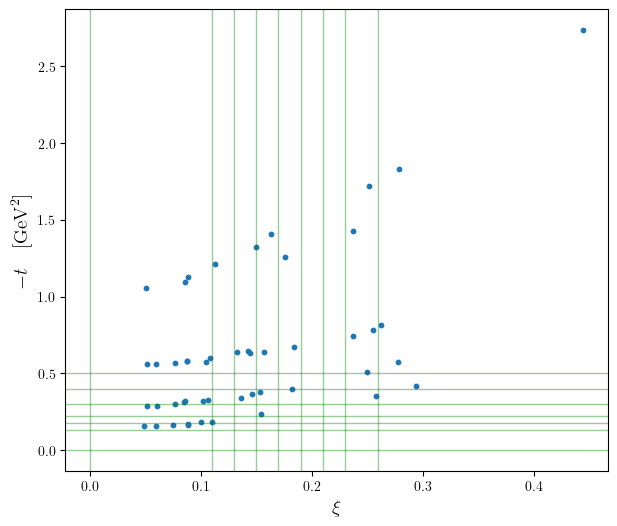

In [11]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSA.xi, BSA.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

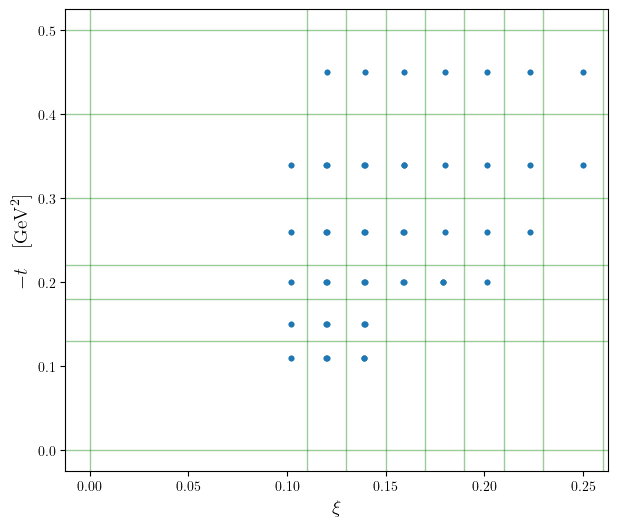

In [12]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSS.xi, BSS.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

## Fit with NeuralModel

In [13]:
#class NNTest(g.model.NeuralModel, g.eff.KellyEFF, g.dvcs.BM10tw2):
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BMK):    

    def build_net(self):
            '''Overriding the default architecture and optimizer'''
            nn_model = torch.nn.Sequential(
                    torch.nn.Linear(2, 23),
                    torch.nn.ReLU(),
                    torch.nn.Linear(23, 37),
                    torch.nn.ReLU(),
                    torch.nn.Linear(37, 19),
                    torch.nn.ReLU(),
                    torch.nn.Linear(19, len(self.output_layer))
                )
            optimizer = torch.optim.Rprop(nn_model.parameters(), lr=0.01 ) #lr=0.05 #2e-3
            return nn_model, optimizer

In [14]:
g.describe_data(fitpoints)
th = NNTest(output_layer=['ImH', 'ReH']) # , q2in=True)
print(th.useDR)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
49 x ALU     CLAS    -1     182 arxiv.org/pdf/2211.11274
32 x ALU     CLAS    -1     192 arxiv:2211.11274
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 237
None


In [15]:
f = g.fitter.NeuralFitter(fitpoints, th, nnets=10, batchlen=10, regularization='L2', lx_lambda=0.002)
#f.fitgood()
f.fit()
torch.save(th.nets, 'Test_dataset1_nets.tar')

/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch  10: train error = 2.0545 test error = 2.3464 -
Epoch  20: train error = 1.7085 test error = 1.9362 -
Epoch  30: train error = 1.4942 test error = 2.0483 +
Epoch  40: train error = 1.3838 test error = 2.0759 +
Epoch  50: train error = 1.3291 test error = 2.1506 +
Epoch  60: train error = 1.2809 test error = 2.2596 +
Epoch  70: train error = 1.2505 test error = 2.2663 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.936217452728253

Epoch  10: train error = 2.4630 test error = 1.9153 -
Epoch  20: train error = 1.6901 test error = 1.7189 -
Epoch  30: train error = 1.4640 test error = 1.5935 -
Epoch  40: train error = 1.3372 test error = 1.7057 +
Epoch  50: train error = 1.2734 test error = 1.7424 +
Epoch  60: train error = 1.2373 test error = 1.8190 +
Epoch  70: train error = 1.2183 test error = 1.8916 +
Epoch  80: train error = 1.2052 test error = 1.8863 +
No improvement for 5 batches. Stopping early.
Net 1 --> test_err = 1.5934575521425671

Epoch  10: train

### Use shelve to store the trained models

In [21]:
with shelve.open("Models") as shelve_file:
    # Store num list in shelf file 
    
    shelve_file['NoDR'] = th.nets
    NoDR=shelve_file['NoDR']  

    th4 = NNTest(output_layer=['ImH', 'ReH'])
    th4.nets = NoDR  
    print(f"Keys = {list(shelve_file.keys())}")

Keys = ['DR_HE', 'NoDR', 'DR']


### Chi square

In [22]:
th.chisq(fitpoints)

(np.float64(152.80468259128548), 237, np.float64(0.9999950820605946))

### Just a bunch of data with mydataset

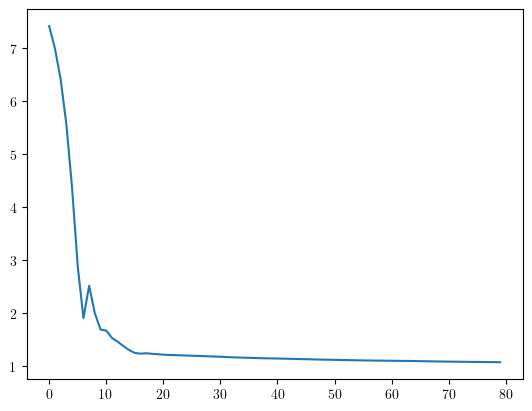

Fit on CLAS data


In [18]:
plt.figure()
plt.plot(f.history)
plt.show()
th.name = "Fit on CLAS data"
print(th.name)

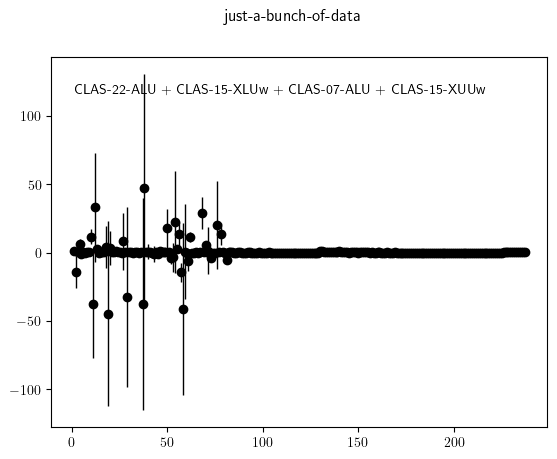

In [19]:
fig = gplot.jbod(points=fitpoints, lines=[th], bands=[th])

### CFFs plots in the no DR case

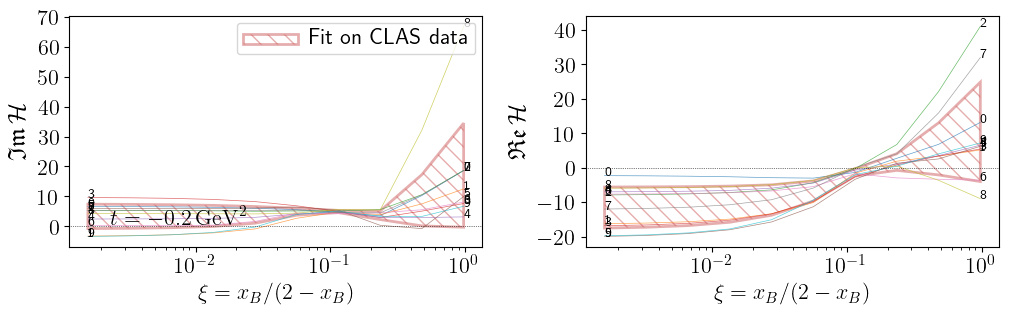

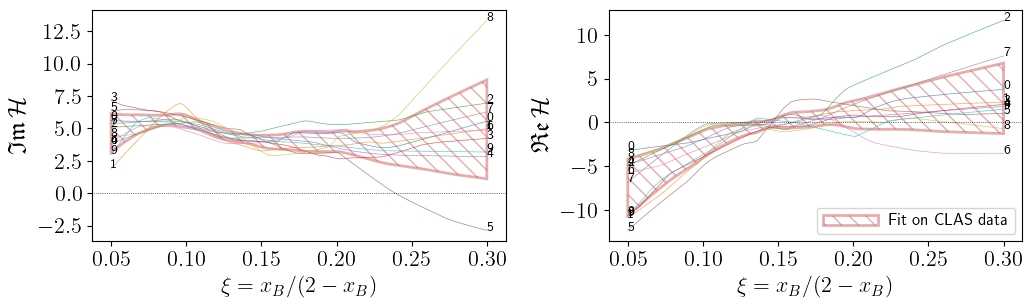

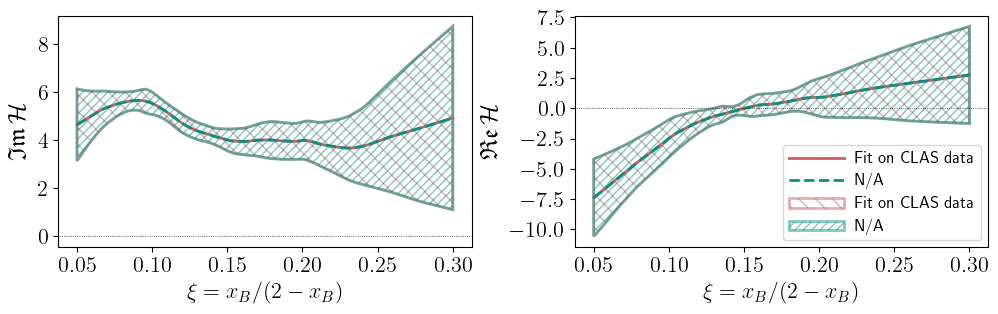

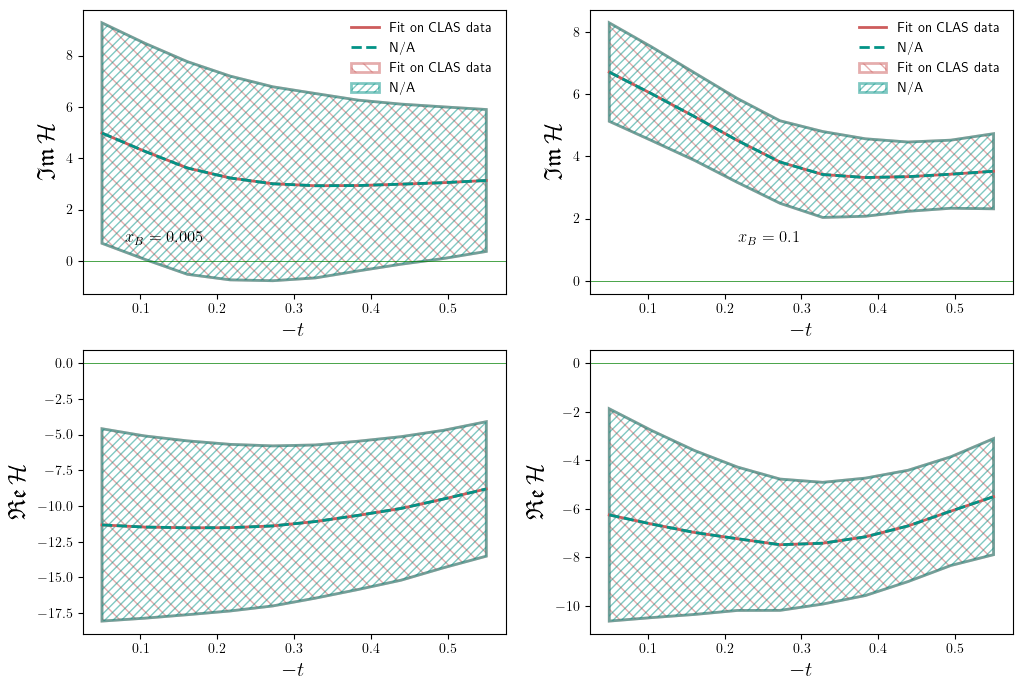

In [23]:
#fig = gplot.CFF3(cffs=['ImH', 'ReH'],  bands=[th], tval=-0.2)
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th, bands=[th], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th, bands=[th])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th4], bands=[th, th4])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th4], bands=[th, th4])
#fig.savefig('NN-mesh.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

## Custom NN

In [24]:
import torch.nn as nn
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)  # 2 input features, 12 hidden units
        self.n2 = nn.Linear(20, 25)  # 12 hidden units, 17 hidden units
        self.n3 = nn.Linear(25, 1)  # 7 hidden units, 1 output features
        
        self.n1p = nn.Linear(1, 20)  # 2 input features, 12 hidden units
        self.n2p = nn.Linear(20, 25)  # 12 hidden units, 17 hidden units
        self.n3p = nn.Linear(25, 1)  # 17 hidden units, 1 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

### Create the class inheriting from DispersionCFF

In [25]:
class NNTest_DR(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(1, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.zero(pt)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [26]:
th2 = NNTest_DR(output_layer=['ImH', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [33]:
#f = g.fitter.NeuralFitter(fitpoints, th2, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
#f.fitgood()
f = g.fitter.NeuralFitter(fitpoints, th2, nnets=10, batchlen=10, regularization='L2', lx_lambda=0.002)
f.fit()
torch.save(th2.nets, 'Test_dataset2_nets.tar')


Epoch  10: train error = 2.0736 test error = 2.5620 -
Epoch  20: train error = 1.8180 test error = 2.4111 -
Epoch  30: train error = 1.7603 test error = 2.3146 -
Epoch  40: train error = 1.7142 test error = 2.4217 +
Epoch  50: train error = 1.6873 test error = 2.5131 +
Epoch  60: train error = 1.6720 test error = 2.4755 +
Epoch  70: train error = 1.6612 test error = 2.4732 +
Epoch  80: train error = 1.6494 test error = 2.4890 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 2.314613718517018

Epoch  10: train error = 1.8284 test error = 2.6219 -
Epoch  20: train error = 1.6170 test error = 2.5614 -
Epoch  30: train error = 1.5594 test error = 3.7644 +
Epoch  40: train error = 1.5324 test error = 4.5053 +
Epoch  50: train error = 1.5153 test error = 3.4736 +
Epoch  60: train error = 1.5043 test error = 3.5111 +
Epoch  70: train error = 1.4908 test error = 3.4967 +
No improvement for 5 batches. Stopping early.
Net 1 --> test_err = 2.561369859937036

Epoch  10: train 

In [34]:
# Use shelve to store the trained models
with shelve.open("Models") as shelve_file:
    # Store num list in shelf file 
    shelve_file['DR'] = th2.nets
    DR=shelve_file['DR']    
    print(f"Keys = {list(shelve_file.keys())}")

Keys = ['DR_HE', 'NoDR', 'DR']


In [35]:
th2.chisq(fitpoints)

(np.float64(166.0859507260991), 237, np.float64(0.9998541849835897))

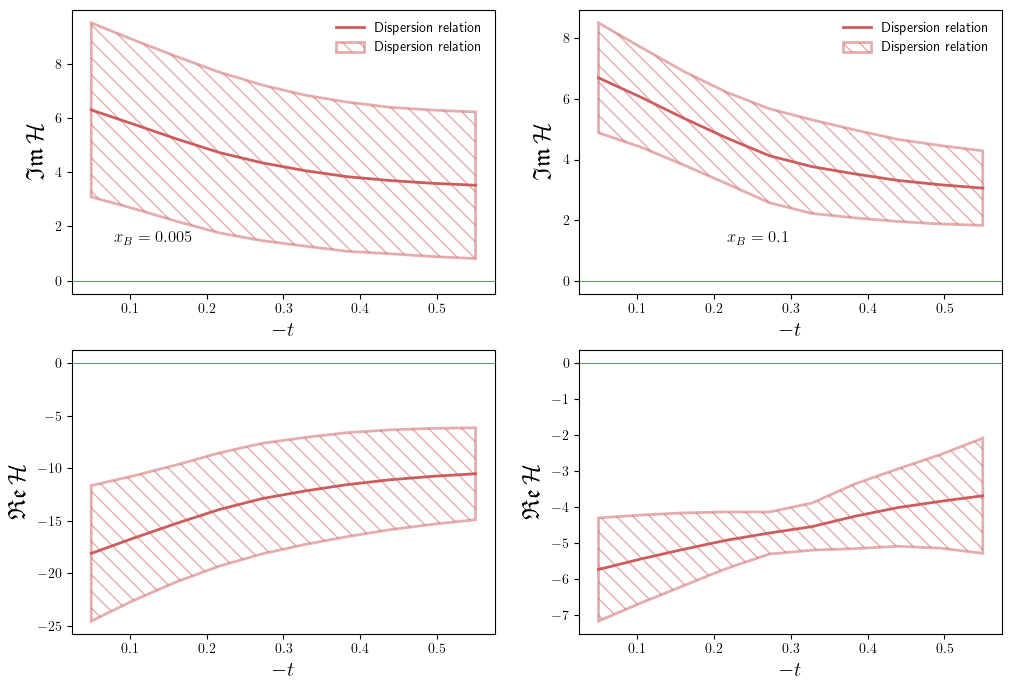

In [36]:
th2.name = "Dispersion relation"
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=th2, bands=[th2])

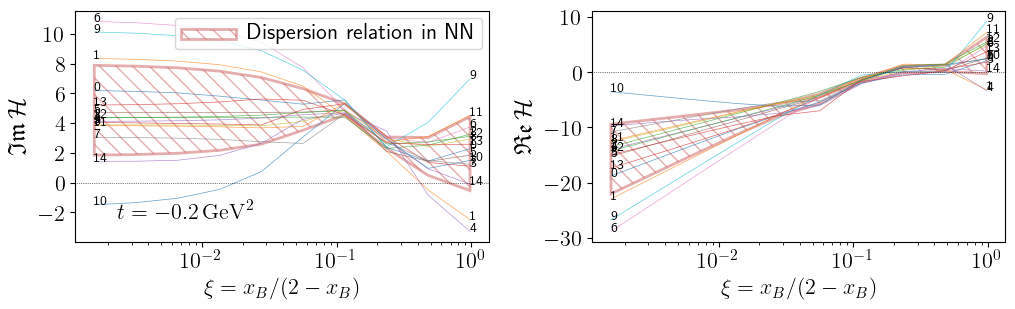

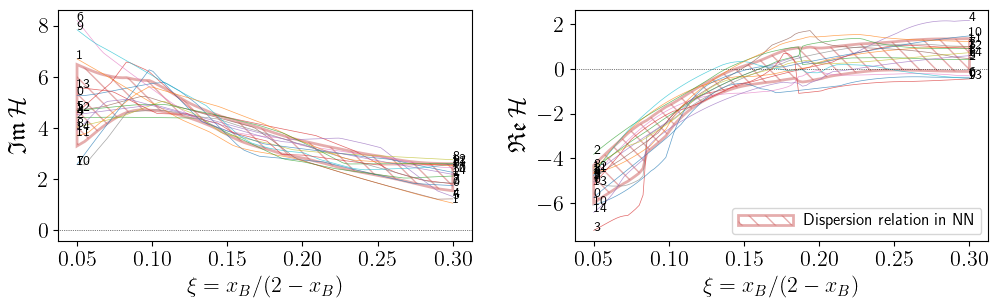

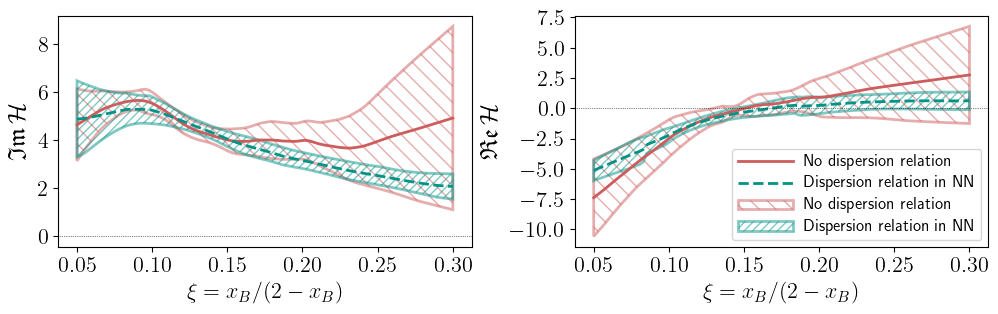

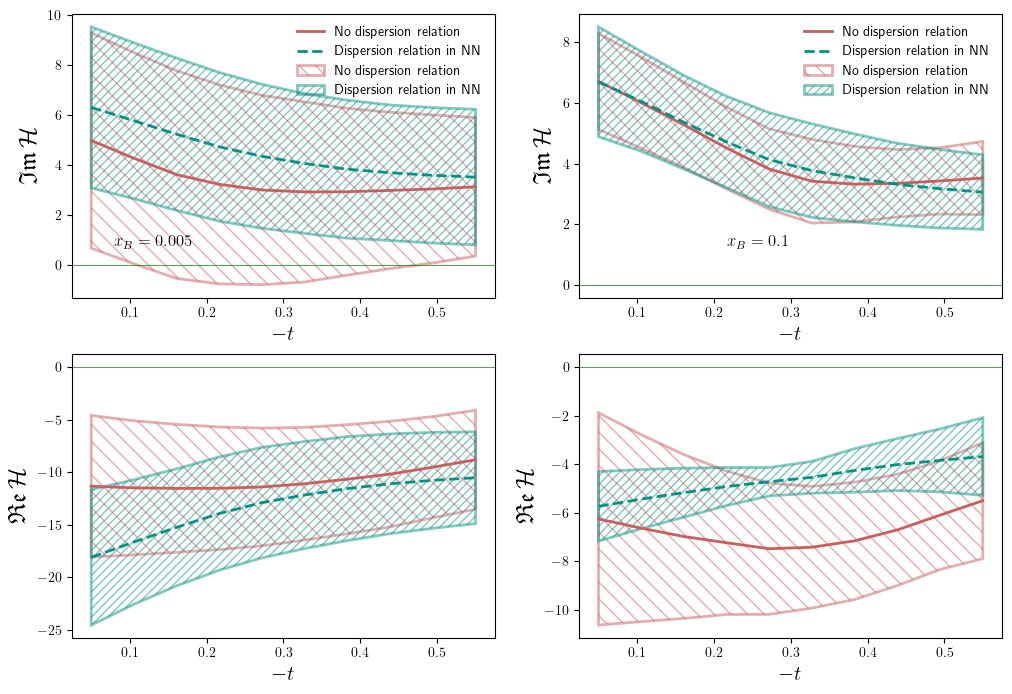

In [37]:
th.name = "No dispersion relation"
th2.name = "Dispersion relation in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])

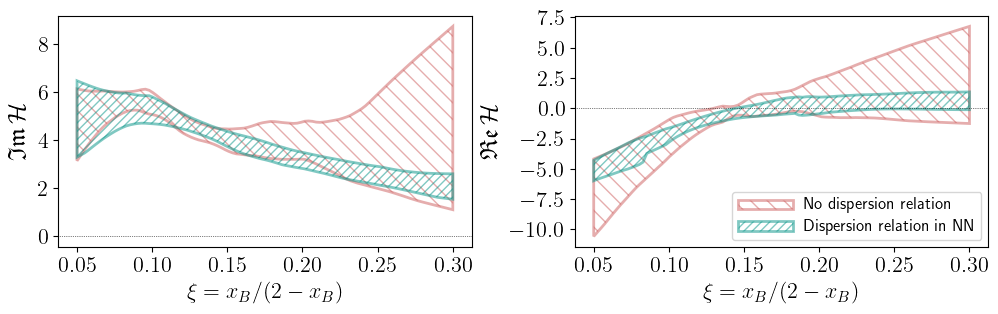

In [38]:
fig = gplot.CFF3(cffs=['ImH', 'ReH'], bands=[th, th2])

## Test with 4 CFFs

In [39]:
class CustomNetwork_4(nn.Module):
    def __init__(self):
        super(CustomNetwork_4, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)  # 2 input features, 7 hidden units
        self.n2 = nn.Linear(20, 25)  # 7 hidden units, 7 hidden units
        self.n3 = nn.Linear(25, 2)  # 7 hidden units, 2 output features
        
        self.n1p = nn.Linear(1, 20)  # 2 input features, 7 hidden units
        self.n2p = nn.Linear(20, 25)  # 7 hidden units, 7 hidden units
        self.n3p = nn.Linear(25, 1)  # 7 hidden units, 2 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

In [40]:
class NNTest_DR_4(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork_4()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #print("I am here in D")
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(2, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.cffs(1, pt, xi)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [41]:
th3 = NNTest_DR_4(output_layer=['ImH', 'ImE', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [42]:
f = g.fitter.NeuralFitter(fitpoints, th3, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
f.fitgood()
torch.save(th3.nets, 'Test_dataset3_nets.tar')


Epoch  10: train error = 2.1599 test error = 2.2302 -
Epoch  20: train error = 1.9181 test error = 1.8932 -
Epoch  30: train error = 1.7715 test error = 2.2210 +
Epoch  40: train error = 1.7101 test error = 2.1349 +
Epoch  50: train error = 1.6552 test error = 2.1787 +
Epoch  60: train error = 1.6141 test error = 2.1543 +test_err = 1.8931903016076335 < max_test_err = 2 so we accept the net
[Try 1/100] 1 good nets. Last test_err = 1.8931903016076335

Epoch  10: train error = 1.9594 test error = 1.9660 -
Epoch  20: train error = 1.8710 test error = 1.7248 -
Epoch  30: train error = 1.8033 test error = 1.7452 +
Epoch  40: train error = 1.7078 test error = 1.7489 +
Epoch  50: train error = 1.6219 test error = 1.7136 -
Epoch  60: train error = 1.5861 test error = 1.6577 -test_err = 1.6576614788014192 < max_test_err = 2 so we accept the net
[Try 2/100] 2 good nets. Last test_err = 1.6576614788014192

Epoch  10: train error = 1.7335 test error = 2.0503 -
Epoch  20: train error = 1.4932 test 

In [43]:
with shelve.open("Models") as shelve_file:
    # Store num list in shelf file 
    shelve_file['DR_HE'] = th3.nets
    DRHE = shelve_file['DR_HE']
    print(f"Keys = {list(shelve_file.keys())}")

Keys = ['DR_HE', 'NoDR', 'DR']


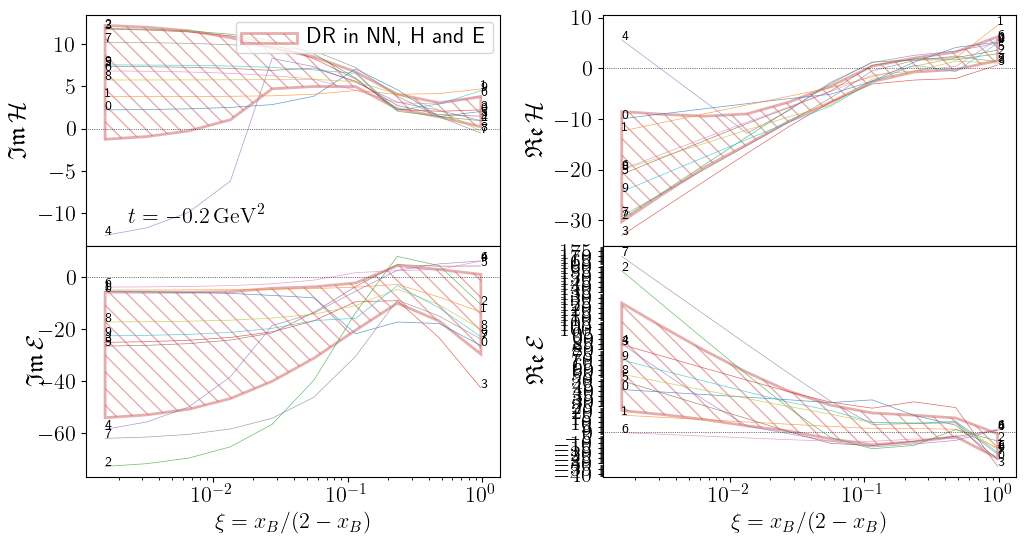

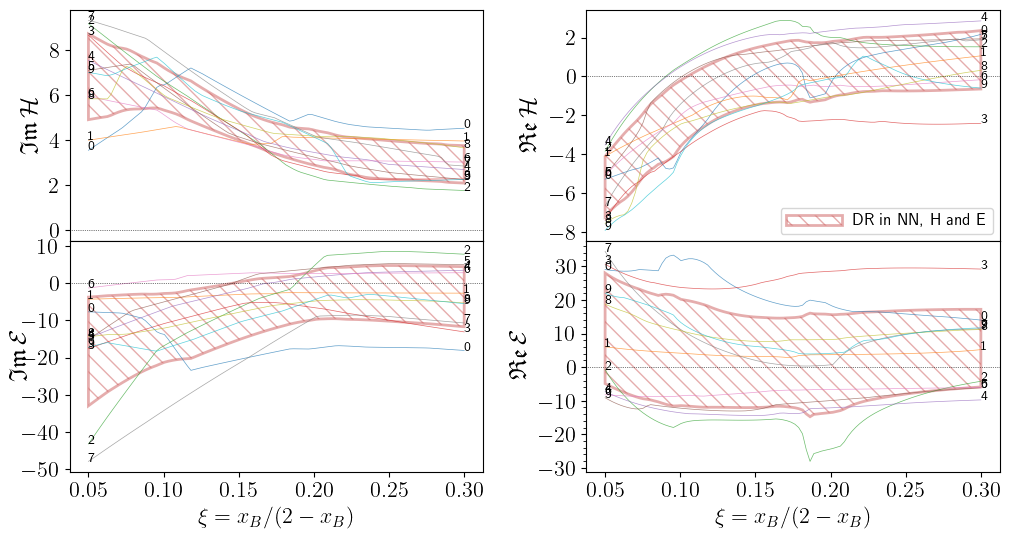

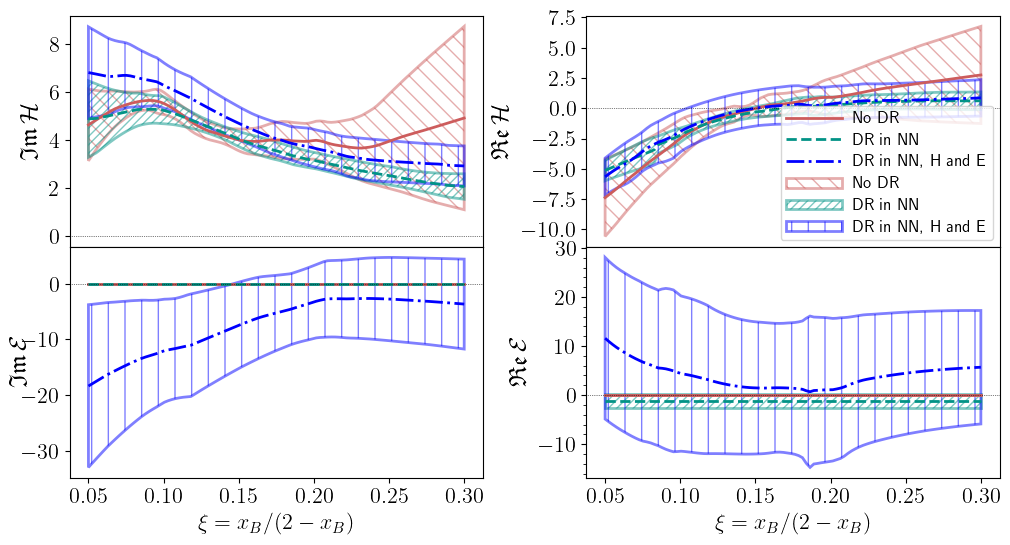

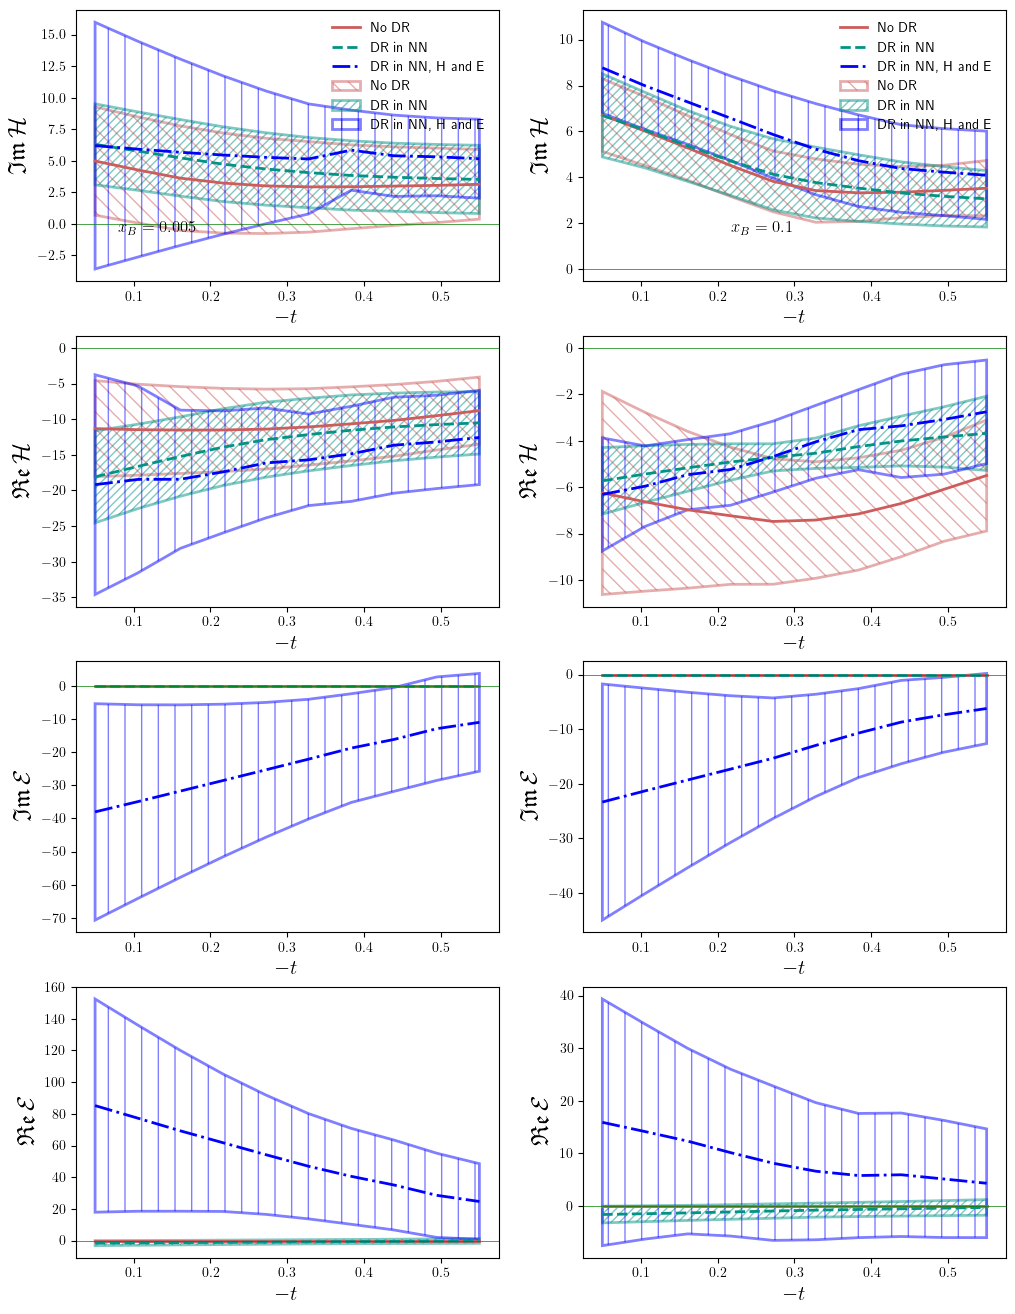

In [44]:
th.name = "No DR"
th2.name = "DR in NN"
th3.name = "DR in NN, H and E"
fig = gplot.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3])
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2, th3], bands=[th, th2, th3])
fig = gplot.CFFt(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2, th3], bands=[th, th2, th3])

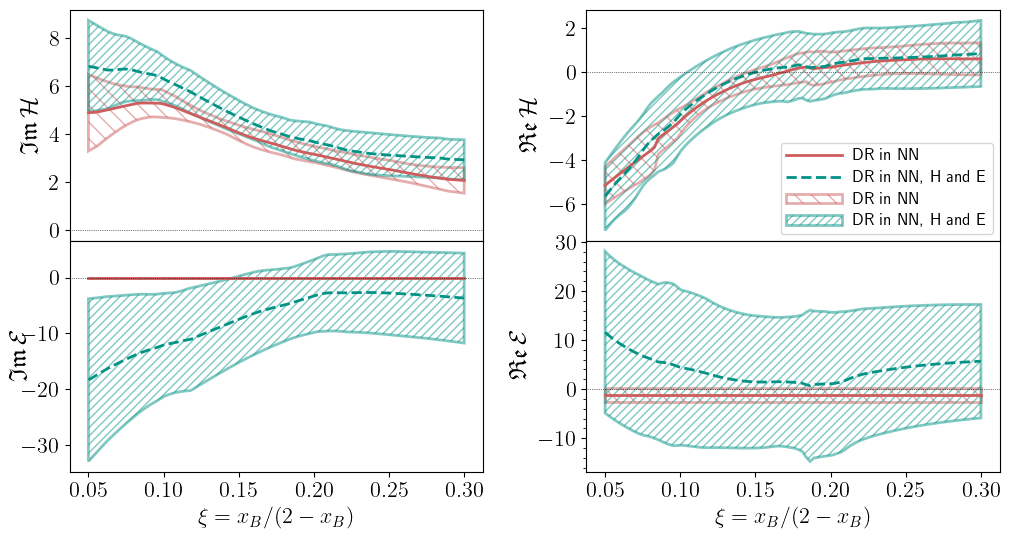

In [45]:
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th2, th3], bands=[th2, th3])

### Describing CLAS data of 2015

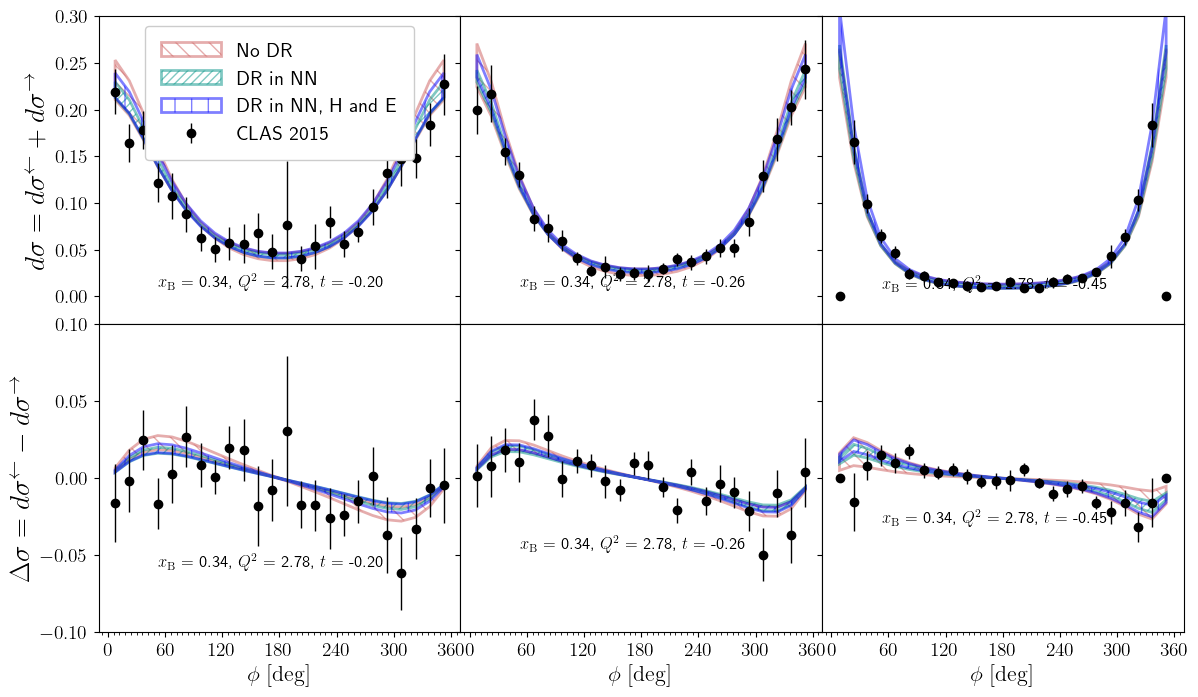

In [46]:
fig = plots.CLAS15phi(bands=[th,th2,th3])

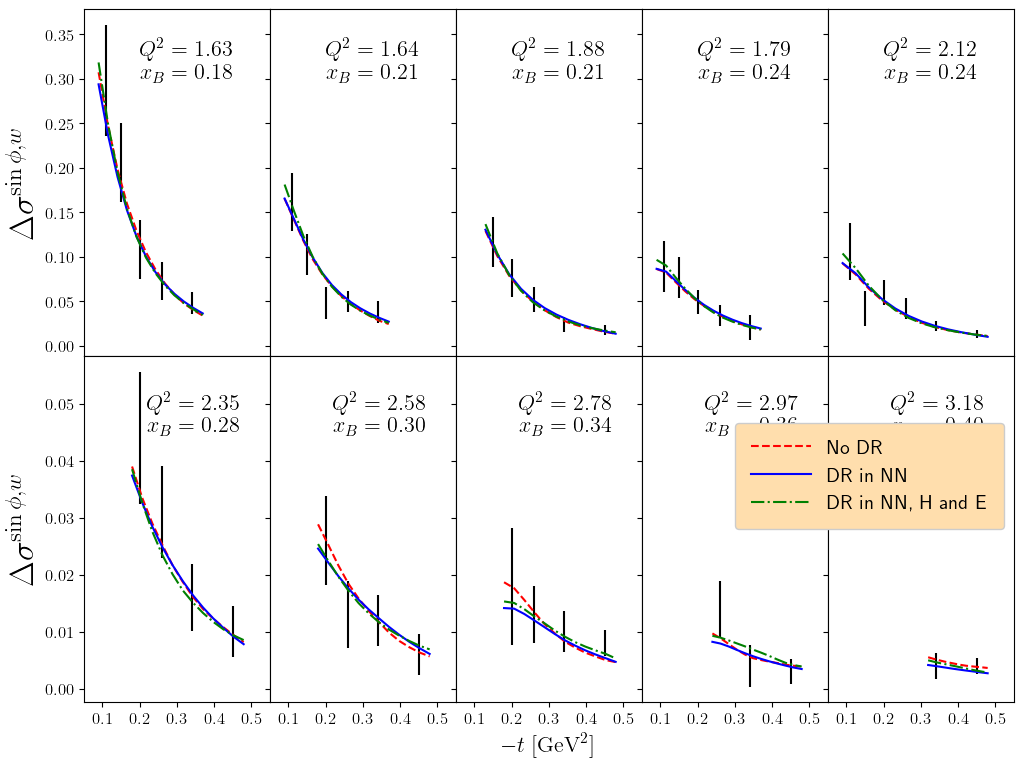

In [47]:
fig = gplot.CLAS15xs(lines=[th,th2,th3])

## D-term using NN

In [48]:
import random
ptts = []
tm_list = [0.1, 0.2, 0.3, 0.4]

for tm in tm_list:
    rndm_idx = random.randint(0, len(tm_list)-1)
    ptb = g.dset[102][rndm_idx].copy()  # take some random point and set/change -t
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)


print(ptts)

[DataPoint: XUUw = 1.437, DataPoint: XUUw = 0.911, DataPoint: XUUw = 0.911, DataPoint: XUUw = 0.911]


In [49]:
th2.name = "DR in NN whit 2 CFFs"
th3.name = "DR in NN with 4 CFFs"

In [50]:
D = []
for th in [th2, th3]:
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for k in range(len(th.m.nets)):
            th.m.parameters['nnet'] = k
            # NOTE: subtraction in code is equal to -\Delta(t) !
            Ds.append(-th.m.subtraction(pt).detach().numpy()*18./25.) 
            #print(-th2.m.ImH(pt).detach().numpy()*18./25.)
        Ds = np.array(Ds)
        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th.m.parameters['nnet'] = 'ALL'    
    D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.4: -0.029005343094468117 +- 3.725290298461914e-09
0.185, -0.3: -0.01226742472499609 +- 9.313225746154785e-10
0.185, -0.2: -0.0779556855559349 +- 0.0
0.185, -0.1: -0.13681446015834808 +- 1.4901161193847656e-08

---- [DR in NN with 4 CFFs - N/A] ----
0.185, -0.4: -0.08323650062084198 +- 7.450580596923828e-09
0.185, -0.3: 0.46586233377456665 +- 2.9802322387695312e-08
0.185, -0.2: 0.810210108757019 +- 5.960464477539063e-08
0.185, -0.1: 1.0586259365081787 +- 1.1920928955078125e-07


In [52]:
np.array(D[1]).mean(axis=0)*(25./18.)

array([3.47222222e-01, 7.81757597e-01, 7.50232074e-08])

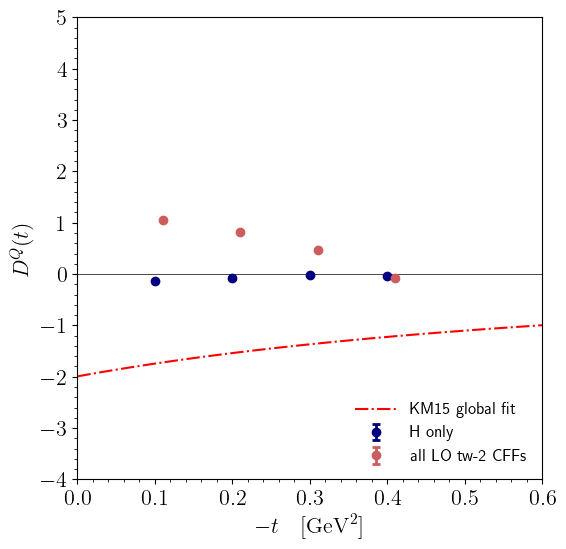

In [53]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H only')
ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
            capsize=3, capthick=2, marker='o', color='indianred', label='all LO tw-2 CFFs')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4, 5)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 

## Pressure Distribution
### Code for pressure in terms of D-term

In [ ]:
def Dterm(t, D0=-1.6, M=0.7, p=3):
    """D-term parametrization"""
    return D0/(1-t/M**2)**p

In [ ]:
# Plotting this D-term
fig, ax = plt.subplots(1, 1, figsize=[7,5])
tms = np.linspace(0,2)
ax.plot(tms, Dterm(-tms), 'b-')
ax.set_ylabel(r'D(t)', fontsize=14)
ax.set_xlabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-2,0)
# fig.savefig('figs/dterm.pdf')

In [ ]:
def pressureNnaive(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    intg = quad(lambda t: np.sin(np.sqrt(-t)*rGeV)*t*Dterm(t, **args), -np.inf, 0, epsabs=0)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

In [ ]:
def pressureN(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    # variable change x=-t^2, so QUADPACK Fourier integral method can be used
    intg = quad(lambda x: 2*x*(-x**2)*Dterm(-x**2, **args), 0, np.inf, weight='sin', wvar=rGeV)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

In [ ]:
def pressureA(r, D0=-1.6, M=0.7, p=3):
    """Pressure distribution r^2*p(r) in GeV/fm for specific Dterm(t) function
    
     D(t) = D0/(1-t/M^2)^p  with p=2 or 3
    
    """
    GeVfm = 0.197
    Mp = 0.938
    assert p in [2,3]
    rGeV = r/GeVfm
    res = D0 * M**(2+p) * rGeV**(p-3) * np.exp(-M*rGeV) * (M*rGeV - p)
    return rGeV**2 * res / (2**(2*p) * 3 * np.pi * Mp) / GeVfm


In [ ]:
D0val, Mval, pval = -1.6, 0.7, 3
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

In [ ]:
D0val, Mval, pval = -1.6, 1.3, 2
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

In [ ]:
pressure = pressureN

## Pressure distribution - mean values

In [ ]:
# Plotting the distribution for ChiQSM parameters from hep-ph/0702030
# d_1(0) = -2.35, M = 0.646,  so D(0) = 1.88
fig, ax = plt.subplots(1, 1, figsize=[7,5])
rs = np.linspace(0.001,2,100)
ps = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=-1.88, M=0.646, p=2))
ax.plot(rs, ps, 'r-', label='ChiQSM')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
#fig.savefig('figs/pressure.pdf')

In [ ]:
Mval = np.sqrt(1.06)
D0val = -2.04 * (4./5.) # d_1 is grav. form. fact.
D0valA = -2.04 * (18./25.)  # d_1 is subtr. const
D0valB = -2.04 * (18./25.)*(5./9.)  # wild guess
fig, ax = plt.subplots(1, 1, figsize=[7,7])
rs = np.linspace(0.001,2,100)
ps = []
psA = []
psB = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=D0val, M=Mval, p=2.76))   
    psA.append(pressure(r, Dterm, D0=D0valA, M=Mval, p=2.76))
    psB.append(pressure(r, Dterm, D0=D0valB, M=Mval, p=2.76))
ax.plot(rs, ps, 'b--', label='d1 is grav. FF')
ax.plot(rs, psA, 'r-', label='d1 is subtr. const.')
ax.plot(rs, psB, 'k-.', label='wild guess')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.001))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))

### Pressure distribution - uncertainties

In [ ]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = np.sqrt(0.14**2 + 0.33**2) * (18./25.)*(5./9.)
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [ ]:
# Sampling from Gaussian/normal distribution using scipy's stats routines
ss = 50 #  sample size
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [ ]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

In [ ]:
# I need to use "wild guess" option above to get agreement Fig. from Nature
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='limegreen',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
#fig.savefig('figs/pressure_nat.pdf')

In [ ]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = 1.4 * (18./25.)  # as seen above, this is essentially t-independent
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [ ]:
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [ ]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='mediumslateblue',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
#fig.savefig('figs/pressure_NNet.pdf')